In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as signal

In [2]:
import audio2numpy as a2n
x,sr=a2n.audio_from_file("data/yt_1.mp3")

x_l, x_r = x[:,0], x[:,1]

x_l /= np.max(np.abs(x_l))

nperseg = 128
t = np.arange(len(x_l)) / sr

In [3]:
f_no_filt, t_no_filt, zxx = signal.stft(x_l, sr, nperseg=nperseg)
df = pd.DataFrame(np.abs(zxx), columns=t_no_filt, index=f_no_filt)

Text(0.5, 0, 'Time [sec]')

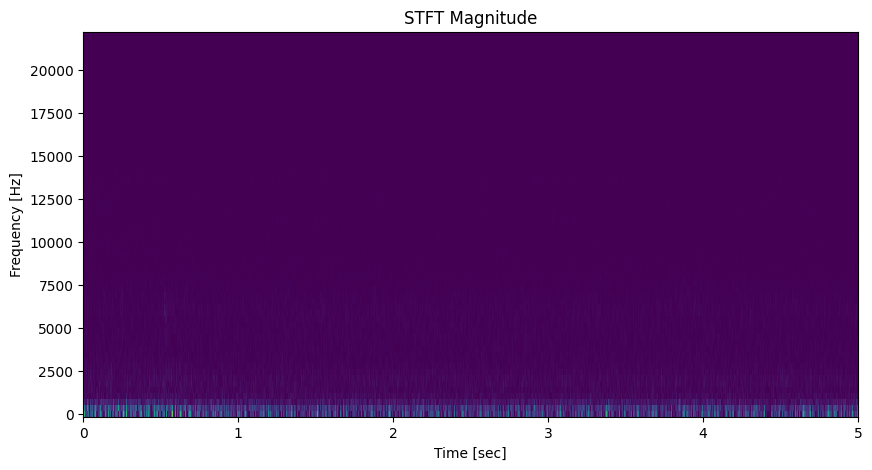

In [4]:
time_before_pop = 5.0
df_before_pop = df[df.columns[df.columns < time_before_pop]]

fig, ax = plt.subplots(figsize=(10, 5))
ax.pcolormesh(df_before_pop.columns, df_before_pop.index, df_before_pop)
ax.set_title('STFT Magnitude')
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [sec]')

Text(0.5, 0, 'Time [sec]')

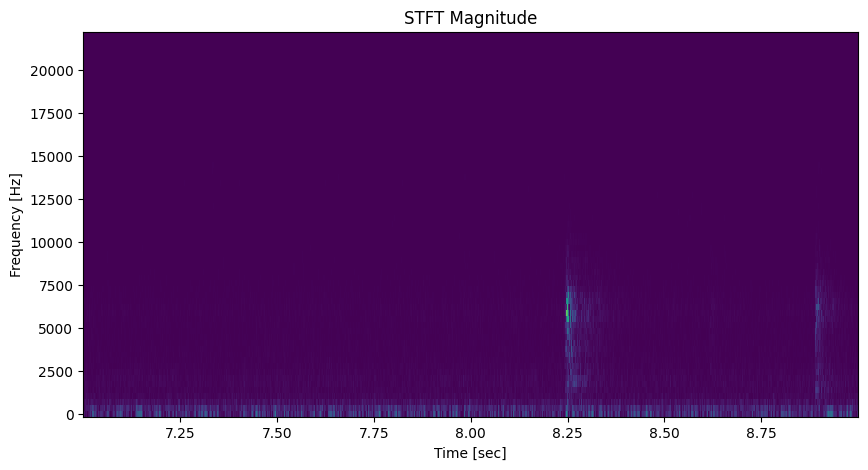

In [5]:
pop_interval = (7.0, 9.0)
df_pop_interval = df[df.columns[(df.columns > pop_interval[0]) & (df.columns < pop_interval[1])]]

fig, ax = plt.subplots(figsize=(10, 5))
ax.pcolormesh(df_pop_interval.columns, df_pop_interval.index, df_pop_interval)
ax.set_title('STFT Magnitude')
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [sec]')

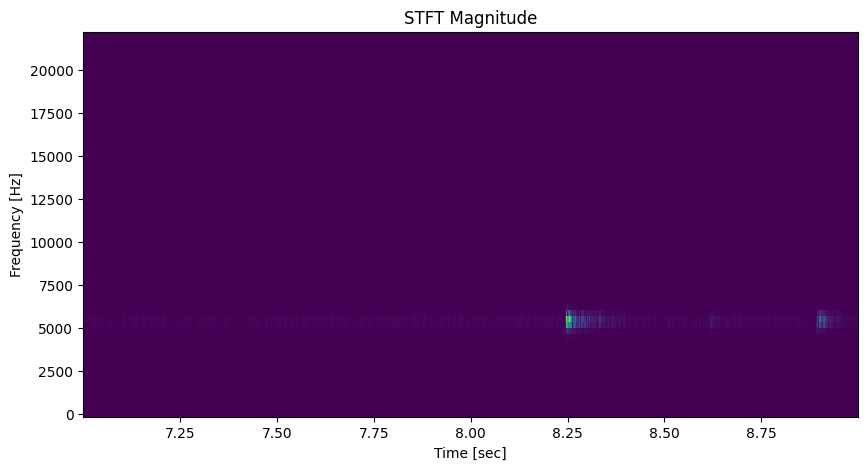

In [6]:
f_pop_interval = (5250, 5500)
filter_coefs = signal.butter(3, f_pop_interval, btype='bandpass', fs=sr, output='sos')
x_l_filt = signal.sosfilt(filter_coefs, x_l)

f_filt, t_filt, zxx_filt = signal.stft(x_l_filt, sr, nperseg=nperseg)
df_filt = pd.DataFrame(np.abs(zxx_filt), columns=t_filt, index=f_filt)

df_filt_pop_interval = df_filt[df_filt.columns[(df_filt.columns > pop_interval[0]) & (df_filt.columns < pop_interval[1])]]

fig, ax = plt.subplots(figsize=(10, 5))
ax.pcolormesh(df_filt_pop_interval.columns, df_filt_pop_interval.index, df_filt_pop_interval)
ax.set_title('STFT Magnitude')
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [sec]')
plt.show()

In [7]:
is_in_pop_interval = (t > pop_interval[0]) & (t < pop_interval[1])

x_l_filt_pop_interval = x_l_filt[is_in_pop_interval]
t_pop_interval = t[is_in_pop_interval]

Better CFAR used in [this](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6132514) article by C.J. Venter et.al *Implementation of the CA-CFAR Algorithm for
Pulsed-Doppler Radar on a GPU Architecture*

Also check out [this](https://www.irjet.net/archives/V5/i7/IRJET-V5I7431.pdf)

In [22]:
from src import detect_peaks

min_time_between_pop = 0.1  # s
train_cell_percent = 0.9
n_guard = int(min_time_between_pop * sr * (1 - train_cell_percent))
n_train = int(min_time_between_pop * sr * train_cell_percent)

peaks = detect_peaks(x_l_filt_pop_interval, n_train, n_guard, 0.05)

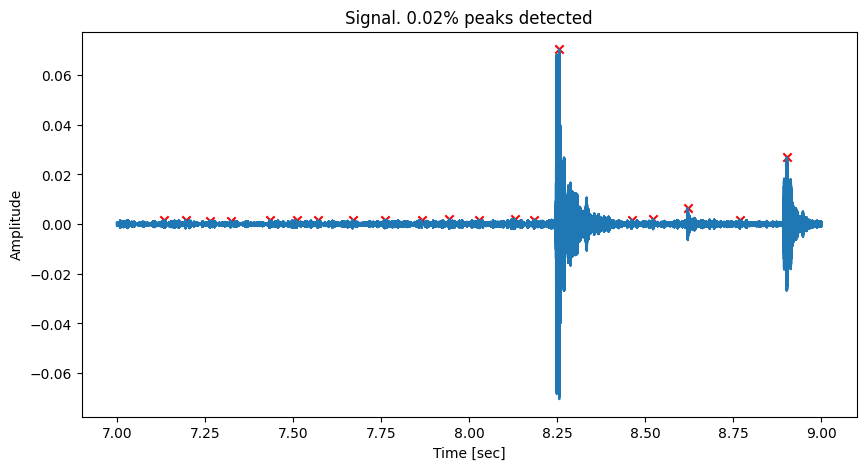

In [23]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(t_pop_interval, x_l_filt_pop_interval)
ax.scatter(t_pop_interval[peaks], x_l_filt_pop_interval[peaks], c='r', marker='x')
ax.set_title(f'Signal. {100*len(peaks) / len(x_l_filt_pop_interval):.2f}% peaks detected')
ax.set_ylabel('Amplitude')
ax.set_xlabel('Time [sec]')
plt.show()

Perhaps check microwave sound level before pop interval

/tmp/ipykernel_122252/3418922305.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax1.set_xticklabels(ax1.get_xticks(), rotation=45)
/tmp/ipykernel_122252/3418922305.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax2.set_xticklabels(ax2.get_xticks(), rotation=45)


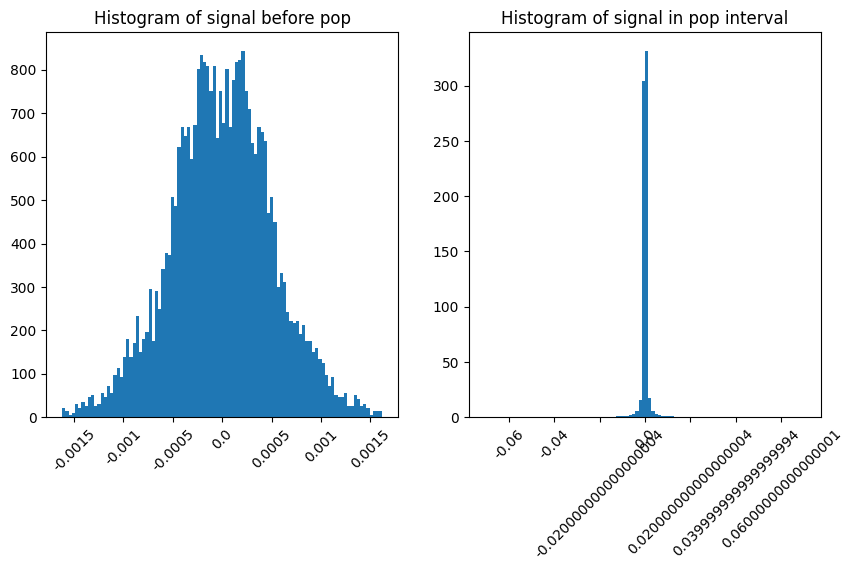

In [43]:
x_l_b4_pop = x_l_filt_pop_interval[:peaks[0]]
t_b4_pop = t_pop_interval[:peaks[0]]

fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)

_ = ax1.hist(x_l_b4_pop, bins=100, density=True)
ax1.set_title('Histogram of signal before pop')
_ = ax1.set_xticklabels(ax1.get_xticks(), rotation=45)

_ = ax2.hist(x_l_filt_pop_interval, bins=100, density=True)
ax2.set_title('Histogram of signal in pop interval')
_ = ax2.set_xticklabels(ax2.get_xticks(), rotation=45)

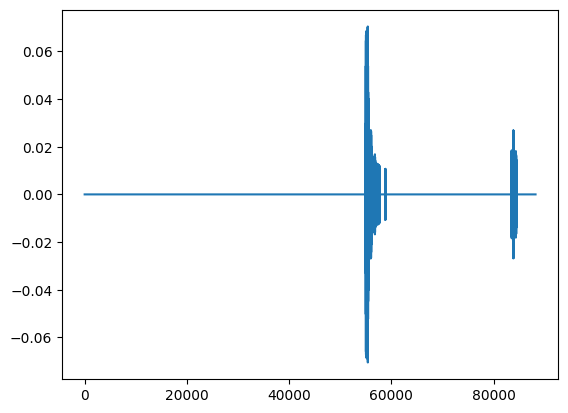

In [56]:
t_pop_interval_zeroed = x_l_filt_pop_interval.copy()
t_pop_interval_zeroed[np.abs(x_l_filt_pop_interval) < np.percentile(x_l_filt_pop_interval, 99)] = 0
plt.plot(t_pop_interval_zeroed)